In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


# Parralel BO with Minimint

Unfortunately BO does not scale as implemented in Spearmint. Inferring points for simulation takes a long time and a single worker working sequentially is not always able to supply points fast enough to fill up large pools of parallel engines. 

The only reasonable solution I found is to perform many Bayesian inferences in parallel. 

The (informal) algorithm is as follows:

1. Submit a batch of simulations on a grid.
2. Wait for a job to finish
3. If the finished job is a simulation job, submit a BO job with the current information of pending and completed simulations (to find the next point to simulate).
4. If the finished job is a BO job, submit a simulation job with the suggested parameters.
5. Repeat 2 - 4 until you had enough...

The class IPP_MinimintOptimizer implements this logic using Ipyparallel. It would be relatively simple to rewrite it for different setups and other tools for distributed computing. I think that writing a more abstract class that can work with many tools is not worth the effort at this time.

The question arises what is the proper way to perform the Bayesian inference in this case, where many similar inferences are running in parallel. How can one avoid the situation where all the choosers pick very similar points? 

There have been a couple of recent proposals (see [here](https://arxiv.org/abs/1705.09236) and [here](https://arxiv.org/abs/1706.01825)) to use this kind of approach with Thompson sampling. The main idea is that instead of averaging over the hyper parameters and possible outcomes of the pending jobs, one simply samples one sample of those and chooses the next point by maximizing the utility function given this sample (in practice one maximizes the utility function over a set of random points). This is supposed to encourage exploration. 

The utility function used in Thompson sampling is simply the function itself. This allows for exploration while still exploiting the known maxima of the function, and supposed to maximize the expected reward over time.
However in a hyperparameter optimization context the goal is not to maximize the overall performance over time but only to find the best point over time. Once a good point is found with high confidence there is no need to continue to sample from it. 
Therefore, I propose to use the Thompson Sampling logic while using EI as the utility function, in order to encourage exploration even after a well performing region is found.

Thus the algorithm would be as follows:

Given a set of completed simulations, $X$, their corresponding values, $\mathbf{v}$ and pending simulations, $X_\mathrm{pend}\,$:

1. Calculate the posterior distribution of the GP hyperparameters $P(\theta | X,\mathbf{v})$ and sample one $\hat{\theta}$ from it.
2. Sample a set of possible simulation results, $\mathbf{\hat v}_\mathrm{pend}\,$, from the distribution $P(\mathbf{\hat v}_\mathrm{pend} | X,\mathbf{v}, X_\mathrm{pend}\,, \hat\theta)$.
3. Calculate the EI given $X,\mathbf{v},X_\mathrm{pend},\mathbf{\hat v}_\mathrm{pend}\,$ and $\hat\theta$ for $n_\mathrm{cand}\,$ candidate points chosen randomly.
4. Return the point with the maximal EI.

Below I give an example that uses GPEIchooser to accomplish this sampling process.

### Note on preformance:

With the current implementation of the Bayesian inference (taken from Spearmint-lite) both inference time and memory requierments increase rapidly with the number of completed  and pending simulations. Thus, with current hardware, the inference is limited to just a few thousand completed and pending samples. 
Overcoming this hurdle will require us to replace the Baysian inference code with a more advanced library that implements approximate Bayesian infernece methods that scale better with the number of samples and perhaps utilises GPUs to speedup the calculation. Possible candidates are maybe [GPflow](https://github.com/GPflow/GPflow), LibBi, [Stan](http://mc-stan.org/), [Edward](http://edwardlib.org/), CrossCat, BayesDB, BayesLite, PyMC.

# Example random function

We start with our target function which is just a 2D Gaussian mixture with random centers and variances.

<IPython.core.display.Javascript object>


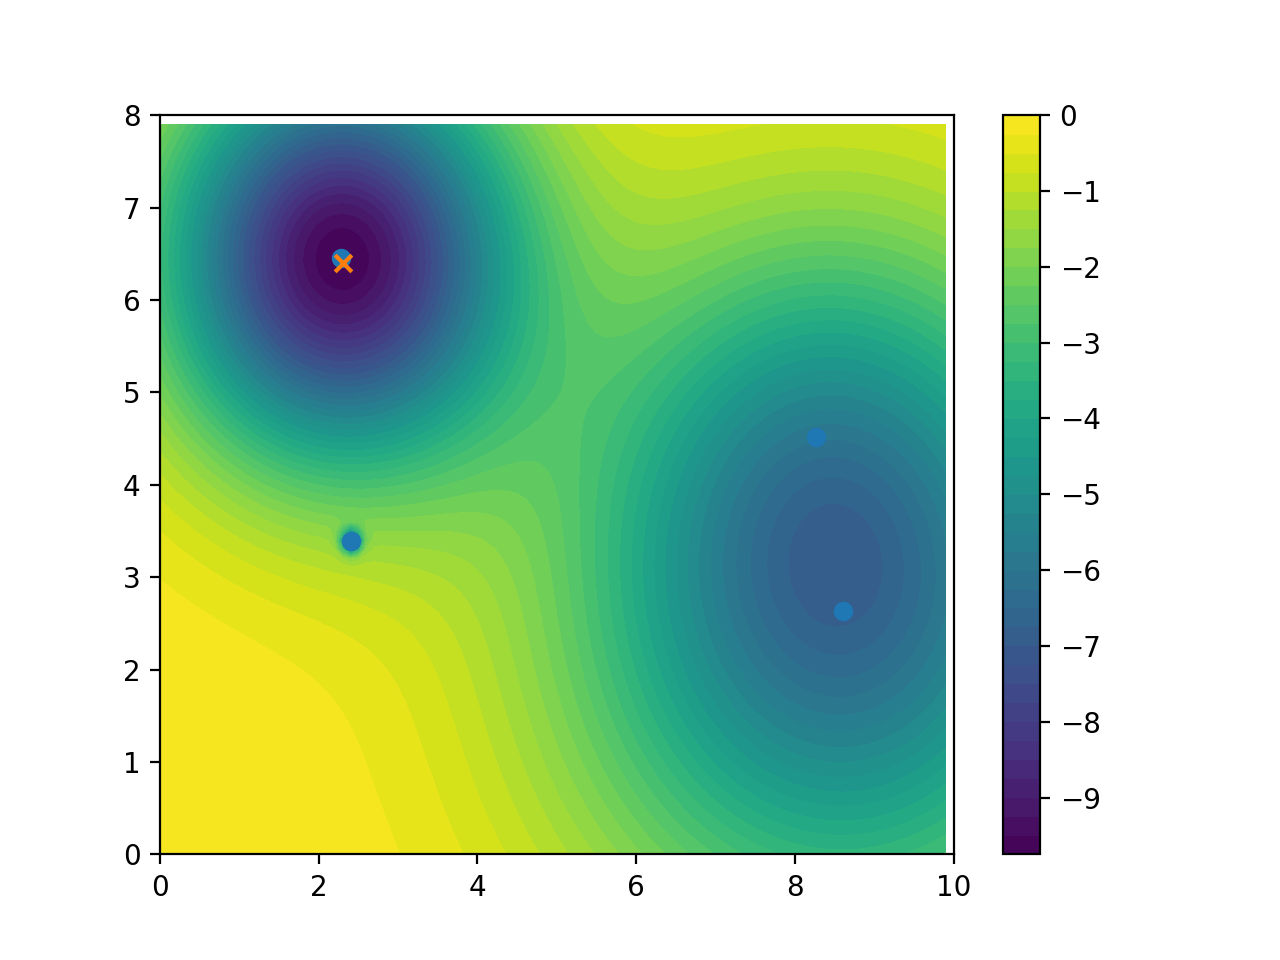

(0, 8)

In [4]:
class random2DGausianMixture(object):
    def __init__(self,xyrange,n,sigma):
        self.centers = [(xyrange[0]*rand(),xyrange[1]*rand()) for i in range(n)]
        self.amplitudes = 10*rand(n)
        self.sigmas = 0.3*np.mean(xyrange)*rand(n)
        self.noise_sigma = sigma
        
    def G(self,r,center,sigma,amp):
        return amp*np.exp(-np.sum((r-center)**2)/(2*sigma**2))
    
    def __call__(self,r):
        gs = [self.G(r,c,s,a) \
                    for c,s,a in zip(self.centers,self.sigmas,self.amplitudes)]
        return -np.sum(gs) + self.noise_sigma*randn()

#create a function on x in [0,10] and y in [0,8] with 6 centers and no noise.
f = random2DGausianMixture((10,8),4,0.)


# plot the example function with the center and minimum
@vectorize
def vec_f(x,y):
    return f(array((x,y)))

x=arange(0,10,.1)
y=arange(0,8,.1)
X,Y = meshgrid(x,y)
F=vec_f(X,Y)
xc=array([c[0] for c in f.centers])
yc=array([c[1] for c in f.centers])

close()
#ploting the function
contourf(X,Y,F,40)
colorbar()
#gauusian centers
scatter(xc,yc)
#global minimum
real_min_ind = argmin(F.flatten())
scatter(X.flatten()[real_min_ind],Y.flatten()[real_min_ind],marker='x')
xlim(0,10)
ylim(0,8)

In [5]:
#set noise level for simulation
f.noise_sigma=0.5

# Plotting

We first define some plotting functions to have some fun graphics during the simulation

In [6]:

from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi,interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

def init_plot():
    #XY = array([HO.gmap.unit_to_list(c) for c in HO.complete])
    XY_pending = array([HO.gmap.unit_to_list(c) for c in HO.pending])
    ms=5
    close()
    fig=figure(figsize=[18/2,12/2])
    ax1=subplot(121)
    cont1=contourf(X,Y,F,20)
    l_complete = plot([],[],ls='none',marker='o',ms=ms,color='b')
    l_pending = plot(XY_pending[:,0],XY_pending[:,1],ls='none',marker='o',ms=ms,color='0.5')
    #best_run = argmin(HO.values)
    l_best = plot([],[],ls='none',marker='o',ms=ms,color='r')
    real_min_ind = argmin(F.flatten())
    scatter(X.flatten()[real_min_ind],Y.flatten()[real_min_ind],marker='x',color='g')
    xlim(-1,11)
    ylim(-1,9)
    

    ax2=subplot(122)
    xlim(-1,11)
    ylim(-1,9)

    tight_layout()
    fig.canvas.draw()
    return fig,ax1,ax2,l_complete[0],l_pending[0],l_best[0]


def update_plot():
    XY = array([HO.gmap.unit_to_list(c) for c in HO.complete])
    XY_pending = array([HO.gmap.unit_to_list(c) for c in HO.pending])
    
    if len(HO.values)>0:
        l_complete.set_data(XY[:,0],XY[:,1])
        best_run = argmin(HO.values)
        l_best.set_data(XY[best_run,0],XY[best_run,1])
    if len(HO.values)>3:
        Xx, Yy, Zz = grid(XY[:,0],XY[:,1],array(HO.values))
        ax2.clear()
        ax2.contourf(Xx, Yy, Zz,20)
        ax2.scatter(XY[best_run,0],XY[best_run,1],color='r')
        ax2.set_xlim(-1,11)
        ax2.set_ylim(-1,9)
    if len(XY_pending)>0:
        l_pending.set_data(XY_pending[:,0],XY_pending[:,1])
    else:
        l_pending.set_data([],[])
    
    fig.canvas.draw()
    plt.draw_all()

## Ipyparallel setup

In [7]:
import ipyparallel as ipp
# We assume the ipyparallel cluster is running
# creating a client direct view and load balance view
ipp_client = ipp.Client()
ipp_dview = ipp_client.direct_view()
ipp_lbview = ipp_client.load_balanced_view()

/usr/local/lib/python3.6/dist-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@parker')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [8]:
%%px 
import os
#change dir of engines to current dir so the could import minimint
os.chdir("/home/ranr/GoogleDrive/RanWork/minimint")

Some remote imports on theh engiens

In [9]:
%%px
import time
import numpy as np
from numpy.random import rand, randn


send the target function to all engine

In [10]:
a=ipp_dview.push({'random2DGausianMixture':random2DGausianMixture})
a=ipp_dview.push({'f':f})
#a.wait()
#a.successful()
a.get()

[None, None, None, None, None, None, None, None]

# Setup for Minimint


We create choosers on engines and define the point selection function

In [11]:
%%px
import time
from numpy.random import rand, randn


from minimint.chooser.GPEIChooser import GPEIChooser

chooser = GPEIChooser()
# chooser performs MCMC iterations over GP hyperparameters to reach equilibrium.
chooser.burn_in_mcmc_iters = 30
# chooser samples one sample from posterior of GP hyper parameters
chooser.mcmc_iters = 1
# number of fantasies for pending jobs (one sample of hypothetical results)
chooser.pending_samples = 1


def select_point(chooser,complete,values,pending,n_cand,D):
    n_complete = complete.shape[0]
        
    if n_complete < 4:
        candidate = np.random.rand(D)
    else:
        candidates = np.random.rand(n_cand,D)
        if pending.shape[0]>0:
            grid = np.vstack((complete,candidates,pending))
            grid_idx = np.hstack((np.zeros(n_complete),\
                              np.ones(n_cand),\
                              1.+np.ones(len(pending)))\
                            )
        else:
            grid = np.vstack((complete,candidates))
            grid_idx = np.hstack((np.zeros(n_complete),\
                              np.ones(n_cand))\
                            )
            
        job_id = chooser.next(grid,\
                              values, np.ones(n_complete),\
                              np.nonzero(grid_idx == 1)[0],\
                              np.nonzero(grid_idx == 2)[0],\
                              np.nonzero(grid_idx == 0)[0])

        # If the job_id is a tuple, then the chooser picked a new job not from
        # the candidate list
        if isinstance(job_id, tuple):
            (job_id, candidate) = job_id
        else:
            candidate = grid[job_id,:]

    return candidate
    

Define the function we will use to run the "simulation" on the engines.

In [12]:
import time

def run_job(params):
    '''
    this function takes parameters from the MinimintOptimizer and runs a simulation 
    with those parameters.
    it should return the job_id as well so that the MinimintOptimizer will be 
    able to asociate the results with the right parameters.
    '''
    # process the parameters 
    x = params[0]
    y = params[1]
    
    # run 'simulation'
    val = f(np.array((x,y)))
    dur = 10*np.random.rand()
    time.sleep(dur)
    
    # return results 
    return val

Create optimizer object and manager object (to keep track of BO results)

In [14]:
from minimint.MinimintAsyncManager import MinimintAsyncManager
from minimint.IPP_MinimintOptimizer import IPP_MinimintOptimizer

from minimint.chooser.GPEIOptChooser import GPEIOptChooser

#define the hyperparameters we want to optimize
#Unlike in spearmint-lite, this should eb a LIST of dictionaries. 
#This mantains the order of variables in the hypercube unnits vector of the params 
#"size" is the dimentionality of the prameter
variables = [
{
  "name":"X",
  "type":"float",
  "min":0,
  "max":10,
  "size":1
},
{
  "name":"Y",
  "type":"float",
  "min":0,
  "max":8,
  "size":1
}
]

#create manager and optimizer. 

HO = MinimintAsyncManager(variables,len(ipp_lbview))

optimizer = IPP_MinimintOptimizer(HO,ipp_client,ipp_lbview,\
                                   process_sim_results = lambda res,info: (res,res),\
                                   save_results = lambda l: update_plot(),\
                                   run_job = run_job,\
                                   select_point = lambda c,v,p: select_point(chooser,c,v,p,100,2),\
                                   pre_init = None,
                                   post_optimization = None)
optimizer.min_n_save = 1 # to call update_plot every time there is a change
optimizer.t_sleep = 0.1 # time between initial jobs
optimizer.max_n_jobs = 150 # max number of points to evaluate


# Optimization using Ipyparaller and Minimint

<IPython.core.display.Javascript object>


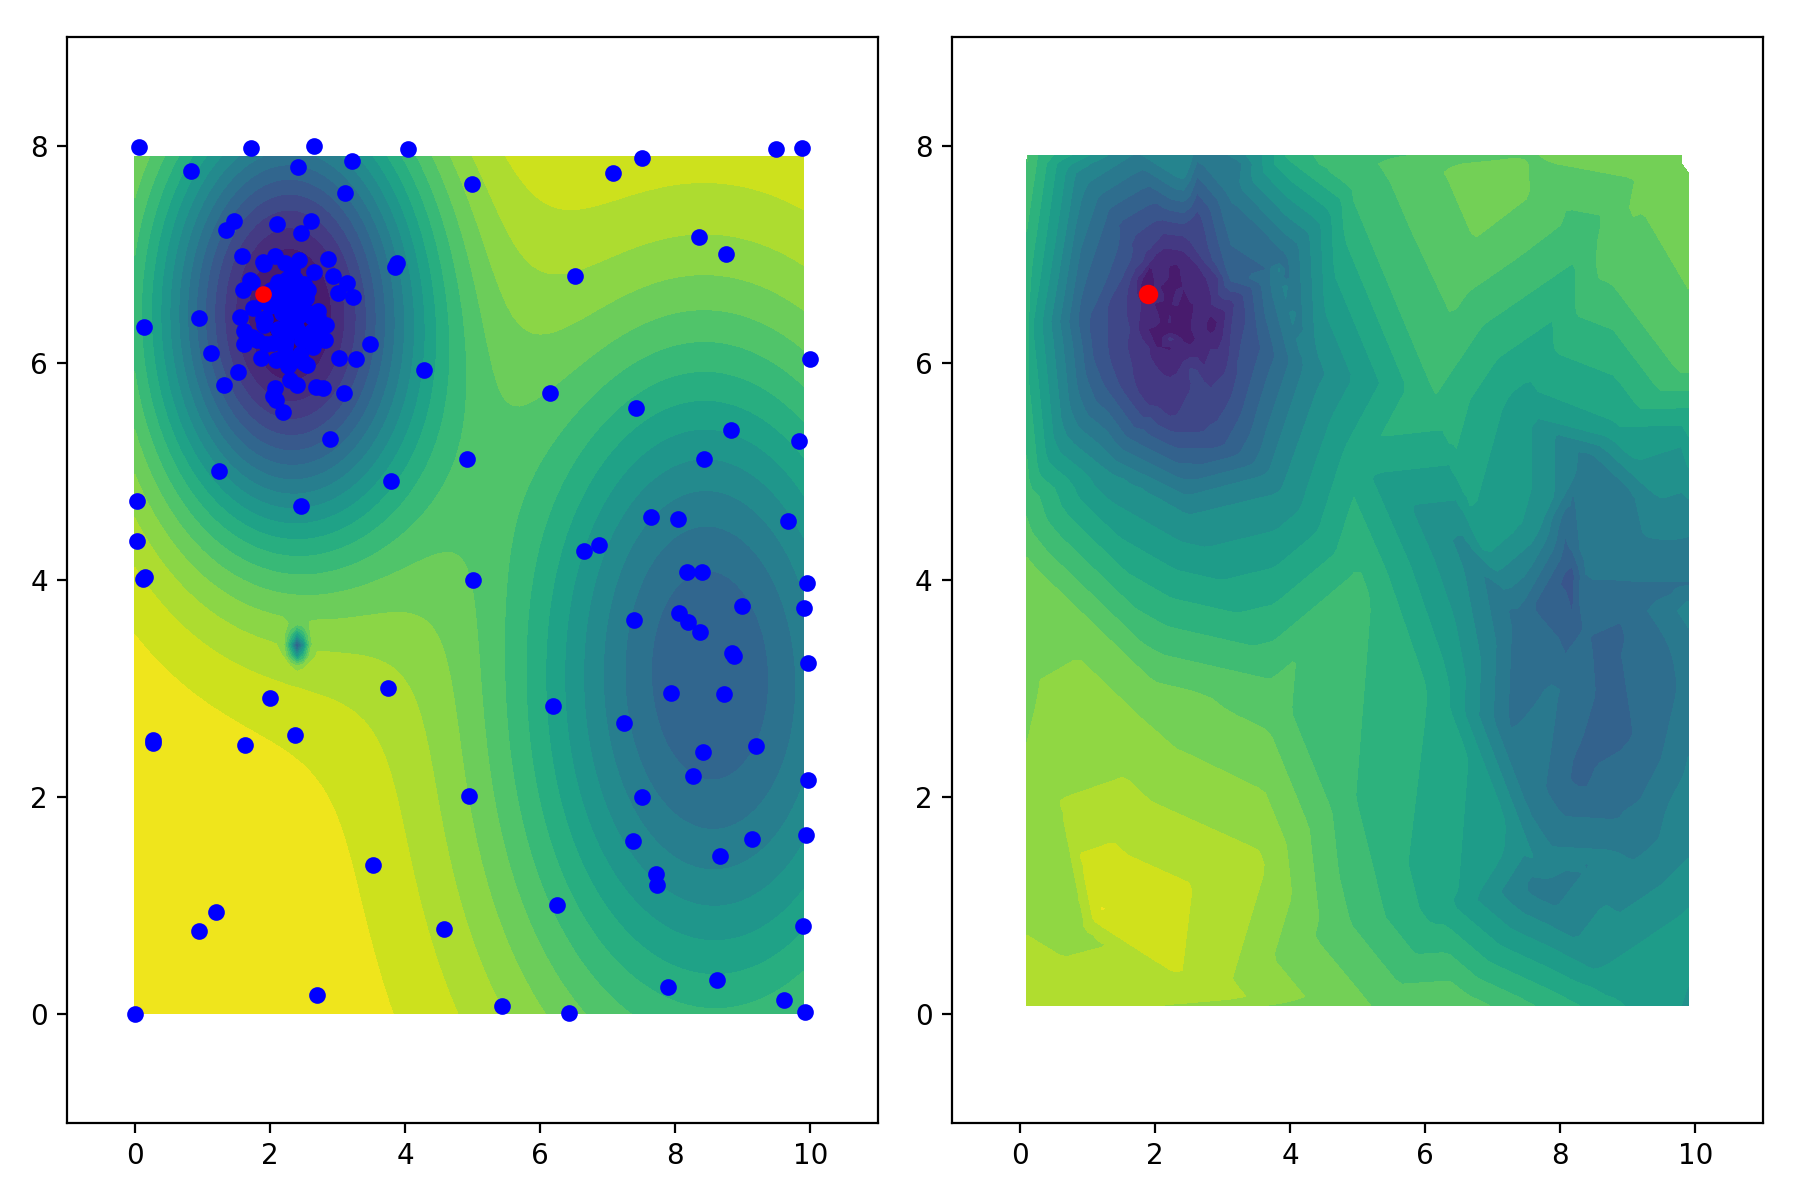

In [15]:
# Show a plot to monitor the simulation
fig,ax1,ax2,l_complete,l_pending,l_best=init_plot() 

In [16]:
optimizer.submit_init() # submits initial points from grid. 
# Can also be used to resume failed optimizations
# given a properly initialized MinimintAsyncManager 
# (with the previous complete,value and pending lists)

optimizer.optimize(wait_time=1e-2) # run optimization. Waiting 1e-2 sec between cluster job checks.

Recived job_id 181, val=-3.33, dur=3.502

15:25:40 Submited 1 chooser jobs. n_jobs=190, N_sim=1, N_BO=7


15:25:41 Saved 2 results. t_save=1.201

Recived job_id 182, val=-7.48, dur=3.316

15:25:42 Submited 1 chooser jobs. n_jobs=191, N_sim=0, N_BO=8

Submited job_id 183. t_BO=42.0
Submited job_id 184. t_BO=44.3
Submited job_id 185. t_BO=39.7
Recived job_id 184, val=-7.16, dur=1.147

15:25:53 Submited 1 chooser jobs. n_jobs=192, N_sim=2, N_BO=6


15:25:54 Saved 2 results. t_save=1.07

Recived job_id 183, val=-7.15, dur=9.006
Recived job_id 185, val=-6.23, dur=1.894

15:25:54 Submited 2 chooser jobs. n_jobs=194, N_sim=0, N_BO=8


15:25:56 Saved 2 results. t_save=1.737

Submited job_id 186. t_BO=34.1
Recived job_id 186, val=-6.97, dur=0.353

15:26:00 Submited 1 chooser jobs. n_jobs=195, N_sim=0, N_BO=8

Submited job_id 187. t_BO=44.6
Submited job_id 188. t_BO=44.5
Recived job_id 187, val=-4.31, dur=6.953

15:26:22 Submited 1 chooser jobs. n_jobs=196, N_sim=1, N_BO=7


15:26:24 Saved 2 res